# Ahead of the Game: Coaching Predictability in NCAA Football

This notebook is Part II in a series that seeks to model the predictability of offenseive playcallers in the NCAA FBS football league. While this idea could be practically applied to any offensive playcaller in the game, we will use Lincoln Riley, the head coach of the Oklahoma Sooners, as a singular case study.

In [Part I](https://colab.research.google.com/drive/1ITENEu7jQ-3Hox3Mxr-TRgueKHElmwCH#offline=true&sandboxMode=true), we used all of Lincoln Riley's called plays to try to predict his coaching behavior. In this notebook, we will explore whether or not Mr. Riley's behavior can be better predicted using a model of the aggregate coaching behavior in the Big XII.

**NOTE: This notebook is meant to be used in [Google Colaboratory](https://colab.research.google.com). The instructions will assume as much, and may not be accurate if you're using a different platform.**

We'll begin just as we did in Part I of the series, by importing the base modules necessary to start and setting a random seed.

In [0]:
from numpy.random import seed
import random

seed(485)
random.seed(485)

In [0]:
import pandas as pd
import numpy as np
import tensorflow

## Preparing our Data

The data we will be using was again scraped from [collegefootballdata.com](https://www.collegefootballdata.com)

Since Oklahoma is a member of the Big XII conference, our dataset will consist of every play that's been run by a Big XII team since Lincoln Riley started at Oklahoma in 2016. As such, it will be much larger than our previous data set.

Again, we will need to import the data. To do this on Google Colab, you will first need to download the "conferenceData.csv" from the models folder in the [GitHub repository](https://github.com/westpoint-neural-networks/final-project-NickL73). Next, you will need to click on the folder icon on the toolbar to the left of Google Colab and upload the dataset.

Once you have done that, load it into a Pandas dataframe and we'll inspect the data.

In [3]:
df = pd.read_csv('/content/conferenceData.csv')
df

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance,play_type
0,-14,False,3,1517,1517,31,1,10,Rush
1,-17,False,3,1017,1017,23,1,10,Rush
2,0,True,1,3600,1800,77,2,12,Rush
3,3,True,2,2700,900,6,1,6,Rush
4,0,True,1,3066,1266,10,1,10,Rush
...,...,...,...,...,...,...,...,...,...
39853,-9,False,2,2070,270,26,2,2,Rush
39854,28,False,4,502,502,8,1,8,Rush
39855,-24,False,4,315,315,1,3,0,Rush
39856,-7,True,1,3476,1676,27,3,9,Rush


Just as before, the data has been to clean certain features and engineer other features before use. Notice that with this dataset, we have about four times as many plays. This will hopefully make our model better, since it has more data to train on.


Now that we have our data in a Pandas data frame, we have to prepare it for use in a neural network. The first step will be to formally define our target values (the play type) and input values (the scoreboard information) by [indexing](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html) our dataframe.

In [0]:
X = df.iloc[:,0:8]
y = df.iloc[:,8]

### Vectorizing the Data

For use in a neural network, each piece of data must be interpretable by a machine. This means things like our values of "True" and "False", as well as our target values of "Rush" and "Pass", must be converted into some number. To do this, we will simply binarize the data.

While we're at it, we'll go ahead and convert our target values into Keras categorical one-hot values.

In [5]:
from keras.utils import to_categorical

X = X.replace({True:1, False:0})
y = y.replace({'Rush':0, 'Pass':1})
y = to_categorical(y)

Using TensorFlow backend.


### Splitting the Data

Like in the coaching notebook, we'll split our dataset into training and validation sets using the scikit-learn [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function

We will again use 85% of the data in the training set, and the remaining 15% of the data in the validation set.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15)

###Scaling and Normalizing the Data

Applying the sklearn [StandardScaler](https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set) to the features of our DataFrame seemed to work pretty well last time.We'll do that again, remembering to only by fit the StandardScaler to our **training data**. It's very important that we do not do this to the validation data at the same time, as that would cause data leakage in the model and decrease the overall accuracy of our model.

In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
numeric = ['score_differential', 'period', 'seconds_remaining', 'secondsInHalf', 'yardsToGoal', 'down', 'distance']
scaled_features = X_train.copy()
features = scaled_features[numeric]
scaler = ss.fit(features.values)
features = ss.transform(features.values)

scaled_features[numeric] = features

X_train = scaled_features
X_train

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance
15772,-1.483643,0,0.431835,-0.447860,0.782926,-0.025787,0.255795,1.624214
19083,0.872721,0,-1.345717,1.141220,0.556796,-1.303528,0.255795,0.108681
29131,-0.675747,0,0.431835,-0.167043,1.318400,-1.344746,-0.951853,0.361270
18799,0.199474,1,-1.345717,1.017889,0.321622,-1.303528,1.463443,0.613858
20836,2.017240,0,0.431835,-0.117711,1.412470,-0.644049,0.255795,-0.901675
...,...,...,...,...,...,...,...,...
22568,-0.069825,1,-1.345717,1.552009,1.340108,-1.221093,-0.951853,0.361270
35182,0.401448,1,-0.456941,0.469537,-0.724000,0.015430,-0.951853,0.361270
17985,1.545968,0,-0.456941,0.401231,-0.854251,1.375606,0.255795,0.361270
174,-1.483643,0,0.431835,-0.294170,1.075989,1.004649,-0.951853,0.361270


Now that we have instantiated a StandardScaler, we can transform all of the values in the **validation set** to the scale of the **training set**.

In [8]:
scaled_features = X_validation.copy()
features = scaled_features[numeric]
features = ss.transform(features.values)

scaled_features[numeric] = features

X_validation = scaled_features
X_validation

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance
25531,0.401448,1,-1.345717,1.493189,1.227948,-0.231875,0.255795,0.361270
9432,0.603422,0,-1.345717,1.267398,0.797398,0.139083,0.255795,-0.901675
17736,-0.069825,1,-1.345717,1.665854,1.557192,1.293171,-0.951853,0.361270
18738,0.401448,1,-1.345717,1.110862,0.498907,1.293171,-0.951853,0.361270
18991,0.872721,0,0.431835,-0.401373,0.871568,-1.179876,1.463443,-0.901675
...,...,...,...,...,...,...,...,...
22280,-0.069825,1,-0.456941,0.515075,-0.637167,-0.561614,-0.951853,0.361270
22421,1.343994,0,-0.456941,0.162157,-1.310127,-0.520397,-0.951853,0.361270
22031,-0.339123,1,1.320611,-1.055979,-0.376666,-0.850136,0.255795,-0.143908
21377,-0.069825,1,-1.345717,1.164938,0.602022,1.210736,-0.951853,0.361270


##Building a Model

So far, we have seen very little difference between the process in this notebook and the process in Part I. Now, however, we will see a major departure from the coaching model we previously created. This network will have a significantly different architecture and thought process behind it, which will hopefully increase our accuracy even more.

**NOTE: Remember that is not a model of Lincoln Riley. Rather, it will be a model of the entire Big XII conference, that we will apply to Lincoln Riley. This is a subtle, but important distinction to make. Even though we might get a high level of predictability for the conference, we still might see low predictability in Lincoln Riley.**

###Model Architecture

Our conference model will be made up of six different layers. Like in the coaching model, we will primarily use Densely connected layers with an **elu** activation function. Notice however, that these Dense layers are separated by a layer of BatchNormalization, which recenters and rescales the input to the next layer. This should help increase the accuracy of our model. Additionally. we specify a lower rate of Dropout.

We will again use a **sigmoid** activation in the final layer and **binary_crossentropy** as our loss function, given that this is still a binary classificaton problem.

Lastly, we will specify a learning rate for **Adam**, our optimizer. We're doing this because we will ultimately use a learning rate reduction callback while training this model. As such, we need to start with a high learning rate so that we have room to decrease it while training the model.

In [0]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(16, activation='elu', input_dim=8))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='elu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='sigmoid'))

ad = optimizers.Adam(learning_rate=0.1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

###Training the Model

With a model defined and compiled, we're ready to begin training.

Before we do so, however, let's write a couple of callbacks that might help us achieve the best model possible.

The first callback we will use will be **EarlyStopping**, which monitors the training progress. If the validation scores stop improving for a certain number of epochs, it will stop the training and restore the weights of the best model we saw during training. This is useful because it allows us to set an arbitrarily high number of epochs for training, without having to worry about getting just the right number of epochs for our model.

Second, we will use **ReduceLROnPlateau**, which reduces our learning rate if the validation loss of our model seems to stall out. This will make our training in the beginning go a little bit faster, but will slow it down as we get closer and closer to a finely tuned model.

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# early stopping if training for more epochs
es_cb = EarlyStopping(monitor = 'val_loss', verbose=1, patience = 25, restore_best_weights=True)

#reduce learning rate on plateau
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

cb_list = [es_cb, rlr_cb]

With these callbacks defined, we're ready to begin training our model while remembering to set a high number of epochs.

In [11]:
history2 = model.fit(X_train, y_train,batch_size=24, epochs=1000, validation_data=(X_validation, y_validation), callbacks=cb_list)

Epoch 1/1000
1412/1412 [==============================] - 3s 2ms/step - loss: 0.6657 - accuracy: 0.6034 - val_loss: 0.6454 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 2/1000
1412/1412 [==============================] - 2s 2ms/step - loss: 0.6488 - accuracy: 0.6200 - val_loss: 0.6400 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 3/1000
1412/1412 [==============================] - 2s 2ms/step - loss: 0.6453 - accuracy: 0.6207 - val_loss: 0.6392 - val_accuracy: 0.6369 - lr: 0.0010
Epoch 4/1000
1412/1412 [==============================] - 2s 2ms/step - loss: 0.6438 - accuracy: 0.6237 - val_loss: 0.6397 - val_accuracy: 0.6351 - lr: 0.0010
Epoch 5/1000
1412/1412 [==============================] - 2s 2ms/step - loss: 0.6431 - accuracy: 0.6245 - val_loss: 0.6381 - val_accuracy: 0.6377 - lr: 0.0010
Epoch 6/1000
1412/1412 [==============================] - 2s 2ms/step - loss: 0.6422 - accuracy: 0.6265 - val_loss: 0.6362 - val_accuracy: 0.6407 - lr: 0.0010
Epoch 7/1000
1412/1412 [======================

If you look at the training history closely, you'll notice that as the validation loss begins to plateau, we automatically reduce the learning rate. Eventually it, and the validation accuracy, plateau and the model stops training. Once it does, it restores the weights of the model after the epoch with lowest validation loss.

Now let's take a look at the model's performance in terms of accuracy.

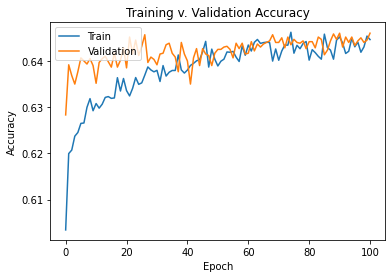

In [12]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training v. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Interestingly, we see evidence of underfitting at the beginning of training but both training and validation accuracies converge around epoch 100. Our restored validation accuracy appears to be 64.61%. This is pretty similar to the coaching model, which might suggest that the Big XII is just about as predictable as Lincoln Riley.

Let's take a look at the loss.

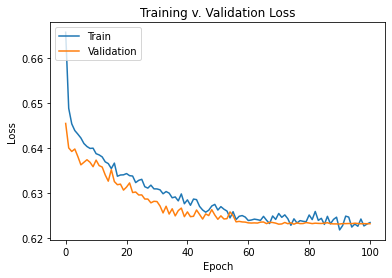

In [13]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training v. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This time, we see a much more gradual convergence of the training and validation losses. This looks pretty good, and they track each other well. Now, we're ready to save and test the model.

**NOTE: The next block of code will save the model to the same content folder as our dataset in the Colab runtime. If you want to keep the model, be sure to right click and download it from the Colab directory.**

In [0]:
model.save('conferenceModel.h5')

##Testing the Model

As we discussed earlier, we built a model of the Big XII conference. This model describes the aggregate predictability of the conference as a whole, but we're going to use it to see if it reveals anything when applied soley to Lincoln Riley.

Again, we're using the 2019 Big XII Championship Game between Oklahoma and Baylor as our test case.

Obviously, we'll start by reading in our test data and manipulating it for use in the model.

In [14]:
testDF = pd.read_csv('/content/test.csv')
XGame = testDF.iloc[:,0:8]
yGame= testDF.iloc[:,8]

XGame = XGame.replace({True:1, False:0})
yGame = yGame.replace({'Rush':0, 'Pass':1, 'FG':2, 'Punt':3})
yGame = to_categorical(yGame)

scaled_features = XGame.copy()
features = scaled_features[numeric]
features = ss.transform(features.values)

scaled_features[numeric] = features

XGame = scaled_features
XGame

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance
0,0,True,1,3595,1795,75,1,10
1,0,True,1,3554,1754,72,2,7
2,0,True,1,3522,1722,70,3,5
3,0,True,1,3337,1537,78,1,10
4,0,True,1,3299,1499,7,1,7
...,...,...,...,...,...,...,...,...
69,0,True,4,119,119,52,2,8
70,0,True,4,74,74,47,3,3
71,0,True,5,-900,-900,23,1,10
72,0,True,5,-900,-900,11,1,10


###Evaluating Performance

Now that the data has been prepared, let's see how well our conference model can predict Lincoln Riley.

In [16]:
model.evaluate(XGame, yGame)

3/3 [==============================] - 0s 2ms/step - loss: 0.6378 - accuracy: 0.6351


[0.6378172636032104, 0.6351351141929626]

Wow, this is a pretty high accuracy given that our final validation accuracy was about 64%. It's also a bit surprising that this model was about 4% more accurate than our coaching model. This suggests that using a model of the Big XII Conference might actually be a better predictor of Lincoln Riley's play calling.

Let's take a deeper look into the performance using sklearn's **classification report**.

In [18]:
from sklearn.metrics import classification_report

Y_test = np.argmax(yGame, axis=1) # Convert one-hot to index
y_pred = np.argmax(model.predict(XGame), axis=1)
print(classification_report(Y_test, y_pred, target_names=['Rush', 'Pass'], digits=5))

              precision    recall  f1-score   support

        Rush    0.73810   0.65957   0.69663        47
        Pass    0.50000   0.59259   0.54237        27

    accuracy                        0.63514        74
   macro avg    0.61905   0.62608   0.61950        74
weighted avg    0.65122   0.63514   0.64035        74



According to the classification report, we see similar behavior to that of the coaching model. Though to a lesser degree, we are still guessing pass more than rush. However, this seems to be a much more balanced and accurate model on the test data.

##Conclusion

This notebook explored the utility of applying a play prediction model based off of the Big XII NCAA football conference to a game of plays called by Lincoln Riley, the head coach of the Oklahoma Sooners. Surprisingly, it did a better job of predicting his behavior than a model based soley on his own history of play calling.

https://colab.research.google.com/drive/1gG2g3m8M6z9hshwrL4Jj_VSWoGZn3zDL
Can we get even better? What would be the result of modeling the coaching behavior of the entire NCAA FBS league and applying it to Lincoln Riley? We'll find out in [Part III](https://colab.research.google.com/drive/1gG2g3m8M6z9hshwrL4Jj_VSWoGZn3zDL#offline=true&sandboxMode=true) of this series.